## MECHENG / CHEMENG 789 Assignment 2

Yixin (Elliott) Huangfu

Using the stock price data, the task is to predict the "open stock price value" using LSTM networks.  

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-01,1.502857,1.560714,1.500000,1.550714,1.034021,90384000
1,2009-12-02,1.542857,1.564286,1.529286,1.538571,1.025924,51324000
2,2009-12-03,1.538571,1.560000,1.497143,1.502143,1.001633,47824000
3,2009-12-04,1.495714,1.512143,1.483571,1.510714,1.007349,44485000
4,2009-12-05,1.492857,1.510714,1.480714,1.489286,0.993060,46544400


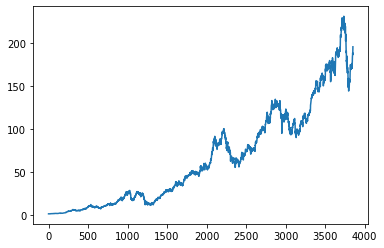

In [4]:
# Show the stock price trends
plt.plot(df.Open)

## Create Dataset

Predict the opening stock price of the data based on the opening stock prices for the past 60 days.

In [5]:
# Create training dataset based on one variable.
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  # copied from tensorflow tutorial.
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # indices = range(i-history_size, i)  # not working on local machine
    sample = dataset[i-history_size:i].values
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(sample, (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
# Data normalization
prices = df.Open.copy()
price_mean = prices.mean()
price_std = prices.std()
prices = (prices - price_mean) / price_std
print('Price data mean = {:.1f}, std = {:.1f}'.format(price_mean, price_std))

X, y = univariate_data(prices, start_index=0, end_index=None, history_size=60, target_size=0)
print(X.shape, y.shape)

Price data mean = 66.0, std = 56.9
(3793, 60, 1) (3793,)


In [7]:
# split train and test data
X_test = X[-60:,:,:]  # test data are more recent ones.
y_test = y[-60:]
X = X[0:-60,:,:]
y = y[0:-60]
print('Train data:', X.shape, y.shape)
print('Test data:', X_test.shape, y_test.shape)

Train data: (3733, 60, 1) (3733,)
Test data: (60, 60, 1) (60,)


In [8]:
# functions to display a sample
def show_plot(plot_data, delta, title):
  # copied from tensorflow tutorial.
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def create_time_steps(length):
  return list(range(-length, 0))

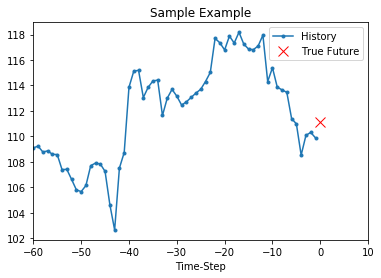

In [9]:
# visualize the data
i = 3200
# restore the actual value
_x = X[i] * price_std + price_mean
_y = y[i] * price_std + price_mean
show_plot([_x, _y], 0, 'Sample Example')
print()

## LSTM Model

Add 3 LSTM layer and a dense layer a last layer of the model

In [10]:
import tensorflow as tf

In [11]:
# Prepare dataset for training.
batch_size = 128    # 3739 / 128 = 30 batches.
buffer_size = 4096   # for shuffling
val_ratio = 0.2
train_size = int(len(y) * (1-val_ratio))

# val dataset is recent data
train_dataset = tf.data.Dataset.from_tensor_slices((X,y))
train_dataset = train_dataset.shuffle(buffer_size)

val_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset = train_dataset.batch(batch_size)

In [15]:
# input_shape should be (n_batches, n_timestep, n_features)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(200,input_shape=(60,1),return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(200,return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(200),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer="adam",
              loss='mse',
              metrics=["mae"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 200)           161600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 200)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 200)           320800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 200)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

Train the model and elaborare /apply hyper-parameter optimization

Tried the following hyper-parameters:
- LSTM units=50, train mae=0.0775, val_mae=0.0481
- LSTM units=100, train_mae=0.0610, val_mae=0.0358
- LSTM units=200, train_mae=0.0530, val_mae=0.0327

In [16]:
history = model.fit(
    train_dataset, epochs=100,
    validation_data = val_dataset,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )

Train for 24 steps, validate for 6 steps
Epoch 1/100
24/24 [==============================] - 42s 2s/step - loss: 0.1510 - mae: 0.2628 - val_loss: 0.0170 - val_mae: 0.1095
Epoch 2/100
24/24 [==============================] - 33s 1s/step - loss: 0.0127 - mae: 0.0857 - val_loss: 0.0052 - val_mae: 0.0492
Epoch 3/100
24/24 [==============================] - 28s 1s/step - loss: 0.0079 - mae: 0.0637 - val_loss: 0.0043 - val_mae: 0.0462
Epoch 4/100
24/24 [==============================] - 43s 2s/step - loss: 0.0074 - mae: 0.0608 - val_loss: 0.0045 - val_mae: 0.0428
Epoch 5/100
24/24 [==============================] - 40s 2s/step - loss: 0.0077 - mae: 0.0605 - val_loss: 0.0038 - val_mae: 0.0413
Epoch 6/100
24/24 [==============================] - 34s 1s/step - loss: 0.0061 - mae: 0.0554 - val_loss: 0.0038 - val_mae: 0.0397
Epoch 7/100
24/24 [==============================] - 33s 1s/step - loss: 0.0062 - mae: 0.0562 - val_loss: 0.0039 - val_mae: 0.0477
Epoch 8/100
24/24 [=======================

## Prediction

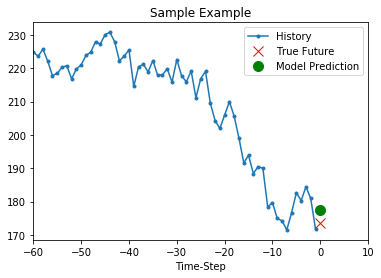

In [17]:
# pick an index in training data
i = 3721     # 0 - 3732

pred = model.predict(X[i:i+1])
# restore the actual value
_x = X[i] * price_std + price_mean
_y = y[i] * price_std + price_mean
_p = pred * price_std + price_mean
show_plot([_x, _y, _p], 0, 'Sample Example')
print()

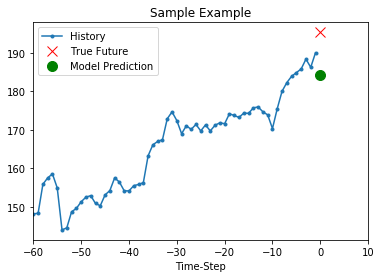

In [62]:
# pick an index in testing data (more recent)
i = 59     # 0 - 59

pred = model.predict(X_test[i:i+1])
# restore the actual value
_x = X_test[i] * price_std + price_mean
_y = y_test[i] * price_std + price_mean
_p = pred * price_std + price_mean
show_plot([_x, _y, _p], 0, 'Sample Example')
print()

## Summary

The result is pretty reasonable. When stock price goes down, model tend to predict a rebounce (```i=50```); and when it's record hight, the model tend to give negative predictions (```i=59```). However, it's not always accurate.